In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
from anndata import AnnData
#import h5py
#import anndata as ad

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

sys.path.append("../")
from args_parser import get_parser
from model.mars import MARS
from model.experiment_dataset import ExperimentDataset
from data.benchmarks import BenchmarkData
import warnings
warnings.filterwarnings('ignore')

/pollard/home/zhhu/miniconda3/envs/mars2/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


# Setting parameters

Loading default parameters

In [2]:
params, unknown = get_parser().parse_known_args()

In [3]:
params

Namespace(cuda=False, epochs=30, epochs_pretrain=25, learning_rate=0.001, lr_scheduler_gamma=0.5, lr_scheduler_step=20, manual_seed=3, model_file='trained_models/source.pt', pretrain=True, pretrain_batch=None)

Checking if CUDA device is available

In [4]:
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'
params.device = device

In [5]:
def init_seed(opt):
    torch.cuda.cudnn_enabled = False
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)
init_seed(params)

# Prepare integrated data

In [6]:
#dat = pd.read_csv("/pollard/home/zhhu/cellwalk/merge_scaledata.csv", index_col = 0) #3000 × 7498
dat = pd.read_csv("/pollard/data/projects/zhhu/cellwalk/merge2_scaledata.csv", index_col = 0) #3000 × 7498

In [7]:
adata = AnnData(dat.values.transpose())
adata

adata.obs_names = dat.columns
adata.var_names = dat.index
print(adata.obs_names[:10])

Index(['Hi_GW21_4.Hi_GW21_4', 'Hi_GW21_5.Hi_GW21_5', 'Hi_GW21_8.Hi_GW21_8',
       'Hi_GW21_1.Hi_GW21_1', 'Hi_GW21_2.Hi_GW21_2', 'Hi_GW21_3.Hi_GW21_3',
       'Hi_GW21_7.Hi_GW21_7', 'Hi_GW21_6.Hi_GW21_6', 'Hi_GW16_11.Hi_GW16_11',
       'Hi_GW16_3.Hi_GW16_3'],
      dtype='object')


In [8]:
#meta = pd.read_csv("/pollard/home/zhhu/cellwalk/merge_metadata.csv", index_col = 0) 
meta = pd.read_csv("/pollard/data/projects/zhhu/cellwalk/merge2_metadata.csv", index_col = 0) 

In [11]:
meta.iloc[4128:4130,:]

,orig.ident,nCount_RNA,nFeature_RNA,WGCNAcluster,Name,Age_in_Weeks,RegionName,Laminae,Area,Subcluster,...,Index,Library,Number_genes_detected,Number_UMI,Percentage_mitochondrial,S_phase_score,G2M_phase_score,Phase,integrated_snn_res.0.8,seurat_clusters
S222.H8,fetalBrain,975641.746817,3341,U4,Sample48,5.85,Presumptive_cortex,All,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,10
GTCCATACTTCA,fetalBrain2,1750.000000,1222,NaN,NaN,NaN,NaN,NaN,NaN,vRG_0,...,N726,Geschwind,1247.0,1775.0,1.13,0.07,-0.05,S,7,7


In [13]:
meta.shape[0] - 4129

6768

In [14]:
adata.obs["ground_truth"] = pd.Categorical(meta.WGCNAcluster[:4129].append(meta.Cluster[4129:]))  # Categoricals are preferred for efficiency
adata.obs["experiment"] = ['science'] * 4129 + ['geschwind'] * (meta.shape[0] - 4129)
adata

AnnData object with n_obs × n_vars = 10897 × 3000 
    obs: 'ground_truth', 'experiment'

In [39]:
adata

AnnData object with n_obs × n_vars = 10897 × 3000 
    obs: 'MARS_labels', 'experiment', 'truth_labels'
    uns: 'neighbors', 'pca', 'experiment_colors'
    obsm: 'MARS_embedding', 'X_pca', 'X_tsne'
    varm: 'PCs'

In [15]:
adata.write('../benchmark_datasets/merge2_neuron.h5ad')

... storing 'experiment' as categorical


# Loading dataset

In [40]:
adata = sc.read_h5ad('../benchmark_datasets/merge2_neuron.h5ad')
adata

AnnData object with n_obs × n_vars = 10897 × 3000 
    obs: 'ground_truth', 'experiment'

In [ ]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.scale(adata, max_value=10, zero_center=True)

... storing 'MARS_labels' as categorical


IndexError: Key "ground_truth" is not valid observation/variable name/index.

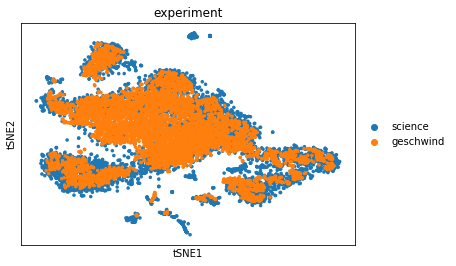

In [37]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
sc.pp.pca(adata, n_comps=50)
sc.tl.tsne(adata, n_jobs = 5 )
sc.pl.tsne(adata, color=['experiment','ground_truth'],size=50)

In [47]:
adata

AnnData object with n_obs × n_vars = 10897 × 3000 
    obs: 'ground_truth', 'experiment'

In [48]:
datasets = list(set(adata.obs['experiment']))
datasets

['geschwind', 'science']

# Train and evaluate MARS

### Use science dataset as annotated, and geschwind as unannotated 

Prepare annotated, unannotated and pretrain datasets

In [49]:
science = adata[adata.obs['experiment'] == 'science',:]
geschwind = adata[adata.obs['experiment'] == 'geschwind',:]

In [50]:
 def celltype_to_numeric(adata, annotation_type):
        """Adds ground truth clusters data."""
        annotations = list(adata.obs[annotation_type])
        annotations_set = sorted(set(annotations))
        
        mapping = {a:idx for idx,a in enumerate(annotations_set)}
        
        truth_labels = [mapping[a] for a in annotations]
        adata.obs['truth_labels'] = pd.Categorical(values=truth_labels)
         
        return mapping

In [51]:
celltype_id_map_science = celltype_to_numeric(science, 'ground_truth')
IDs_to_celltypes_science = {v:k for k,v in celltype_id_map_science.items()}
celltype_id_map_geschwind = celltype_to_numeric(geschwind, 'ground_truth')
IDs_to_celltypes_geschwind = {v:k for k,v in celltype_id_map_geschwind.items()}

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [52]:
y_science = np.array(science.obs['truth_labels'], dtype=np.int64)
annotated = ExperimentDataset(science.X, science.obs_names, science.var_names, 'science', y_science)

== Dataset: Found 4129 items 
== Dataset: Found 47 classes


In [53]:
y_geschwind = np.array(geschwind.obs['truth_labels'], dtype=np.int64) # ground truth annotations will be only used for evaluation
unannnotated = ExperimentDataset(geschwind.X, geschwind.obs_names, geschwind.var_names, 'geschwind', y_geschwind)

== Dataset: Found 6768 items 
== Dataset: Found 16 classes


In [54]:
pretrain_data = ExperimentDataset(geschwind.X, geschwind.obs_names, geschwind.var_names, 'geschwind')

In [55]:
n_clusters = len(np.unique(unannnotated.y))

In [64]:
params.epochs = 100

Initialize MARS

In [65]:
mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)
#mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=200)

Run MARS in evaluation mode. Ground truth annotations will be used to evaluate MARS performance and scores will be returned

In [66]:
# return both annotated and unannotated datasets with save_all_embeddings
adata, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=True) # evaluation mode

Pretraining..

=== Epoch: 100 ===
Train acc: 0.6316299438476562


Check MARS performance

In [26]:
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    #y_true = adjust_range(y_true)
    #y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred, d

In [27]:
from scipy.optimize import linear_sum_assignment 

In [68]:
geschwind = adata[adata.obs['experiment'] == 'geschwind',:]
y_true, y_pred, d = hungarian_match(geschwind.obs['truth_labels'], geschwind.obs['MARS_labels'])

In [71]:
geschwind

View of AnnData object with n_obs × n_vars = 6768 × 3000 
    obs: 'MARS_labels', 'experiment', 'truth_labels'
    obsm: 'MARS_embedding'

In [29]:
d

{0: 6,
 1: 13,
 2: 14,
 3: 10,
 4: 2,
 5: 0,
 6: 8,
 7: 3,
 8: 12,
 9: 9,
 10: 7,
 11: 11,
 12: 1,
 13: 4,
 14: 15,
 15: 5}

In [69]:
name_maps = mars.name_cell_types(adata, landmarks, IDs_to_celltypes_science)


Cluster label: 0
nIN3: 0.00022027952386848617
nIN1: 0.00026807752799845483
nIN5: 0.0005269145580938758
EN-V1-1: 0.0006033168182777771
EN-PFC1: 0.9969778509520678

Cluster label: 1
IPC-div2: 3.64354617480388e-14
MGE-IPC2: 2.3804866562953376e-13
MGE-IPC1: 4.3815015501456975e-13
RG-div2: 0.004036666395086183
RG-div1: 0.9959633336041702

Cluster label: 2
Unassigned

Cluster label: 3
IPC-div2: 0.009072531861829833
MGE-div: 0.020295640185747033
RG-div1: 0.022479803524496446
MGE-IPC2: 0.023529948401970882
MGE-IPC1: 0.9246220734628439

Cluster label: 4
nIN4: 0.022305300794641058
nIN1: 0.022911802533921527
nIN5: 0.03597253368040486
EN-V1-1: 0.036805041605151516
EN-PFC1: 0.6865799295225915

Cluster label: 5
Unassigned

Cluster label: 6
nIN3: 0.03019932229384428
nIN1: 0.0318684107617871
nIN5: 0.039641668349072734
EN-V1-1: 0.05006794545079849
EN-PFC1: 0.4857500137760772

Cluster label: 7
nIN3: 0.03227523376293334
nIN1: 0.034321077567342845
nIN5: 0.045831563227096916
EN-V1-1: 0.047044696476609596


In [72]:
confusion = pd.DataFrame(data=np.zeros((16, 47)), columns = celltype_id_map_science.keys())
for idx in name_maps:
    for x in name_maps[idx]:
        confusion.loc[idx,x[0]] = x[1]

confusion.index = [IDs_to_celltypes_geschwind[d[v]] for v in d.keys()]

In [67]:
confusion.to_csv('geschwind_to_science_confusion2.csv')

In [76]:
confusion.loc['InCGE',]

Astrocyte               0
Choroid                 0
EN-PFC1          0.984617
EN-PFC2                 0
EN-PFC3                 0
EN-V1-1        0.00155198
EN-V1-2                 0
EN-V1-3                 0
Endothelial             0
Glyc                    0
IN-CTX-CGE1             0
IN-CTX-CGE2             0
IN-CTX-MGE1             0
IN-CTX-MGE2             0
IN-STR                  0
IPC-div1                0
IPC-div2                0
IPC-nEN1                0
IPC-nEN2                0
IPC-nEN3                0
MGE-IPC1                0
MGE-IPC2                0
MGE-IPC3                0
MGE-RG1                 0
MGE-RG2                 0
MGE-div                 0
Microglia      0.00409459
Mural                   0
OPC                     0
RG-div1                 0
RG-div2                 0
RG-early                0
U1                      0
U2                      0
U3                      0
U4                      0
nEN-early1              0
nEN-early2              0
nEN-late    